In [1]:
# Instalando as bibliotecas
!pip install tensorflow keras opencv-python-headless matplotlib mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.9 MB/s eta 0:00:00


In [2]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=617f0167e5a95ba0aa5c057bf02d760a6127189d2b96d211dcedecdefe528b9f
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [3]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import img_to_array
from deepface import DeepFace
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN

24-12-09 12:53:02 - Directory /root/.deepface has been created
24-12-09 12:53:02 - Directory /root/.deepface/weights has been created


In [10]:
# carregando o modelo ResNet50
model = ResNet50(weights='imagenet')

In [11]:
# lista com os nomes dos personagens na ordem esperada
character_names = ["Pam", "Jim", "Michael", "Ryan", "Dwight"]

# base de dados com imagens de referencia
reference_images = {
    "Pam": "Pam.jpg",
    "Jim": "Jim.jpg",
    "Michael": "Michael.jpg",
    "Ryan": "Ryan.jpg",
    "Dwight": "Dwight.JPG"
}

In [12]:
# função para calcular embeddings das imagens de referencia
def create_reference_embeddings(reference_images):
    embeddings = {}
    for name, image_path in reference_images.items():
        embedding = DeepFace.represent(img_path=image_path, model_name='Facenet', enforce_detection=False)
        embeddings[name] = embedding[0]["embedding"]
    return embeddings

# criando a base de dados de embeddings
reference_embeddings = create_reference_embeddings(reference_images)

In [13]:
# função para calcular o embedding de uma face detectada
def get_face_embedding(face_image):
    face_resized = cv2.resize(face_image, (224, 224))
    face_array = img_to_array(face_resized)
    face_preprocessed = np.expand_dims(face_array, axis=0)
    # normaliza como o modelo ResNet50 espera
    face_preprocessed = face_preprocessed / 255.0
    # utiliza DeepFace para calcular o embedding facial
    embedding = DeepFace.represent(img_path=face_image, model_name='Facenet', enforce_detection=False)
    return embedding[0]["embedding"]

In [14]:
# detector de faces usando MTCNN
detector = MTCNN()

In [15]:
# função para detectar faces e adicionar os nomes dos personagens
def detect_faces_and_classify_names(image_path):
    # ler a imagem
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # detector de faces
    detector = MTCNN()
    faces = detector.detect_faces(image_rgb)
    face_classifications = []

    for i, face in enumerate(faces):
        x, y, w, h = face['box']
        face_image = image_rgb[y:y+h, x:x+w]

        # calcular o embedding da face detectada
        face_embedding = get_face_embedding(face_image)

        # comparar com os embeddings dos personagens
        best_match_name = None
        best_match_distance = float('inf')
        for name, reference_embedding in reference_embeddings.items():
            # calcula a distancia euclidiana entre os embeddings
            distance = np.linalg.norm(np.array(face_embedding) - np.array(reference_embedding))
            if distance < best_match_distance:
                best_match_distance = distance
                best_match_name = name

        # desenha a face e o rotulo na imagem original
        label = f"{best_match_name} ({best_match_distance:.2f})"
        face_classifications.append(label)
        cv2.rectangle(image_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image_rgb, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    return image_rgb, face_classifications

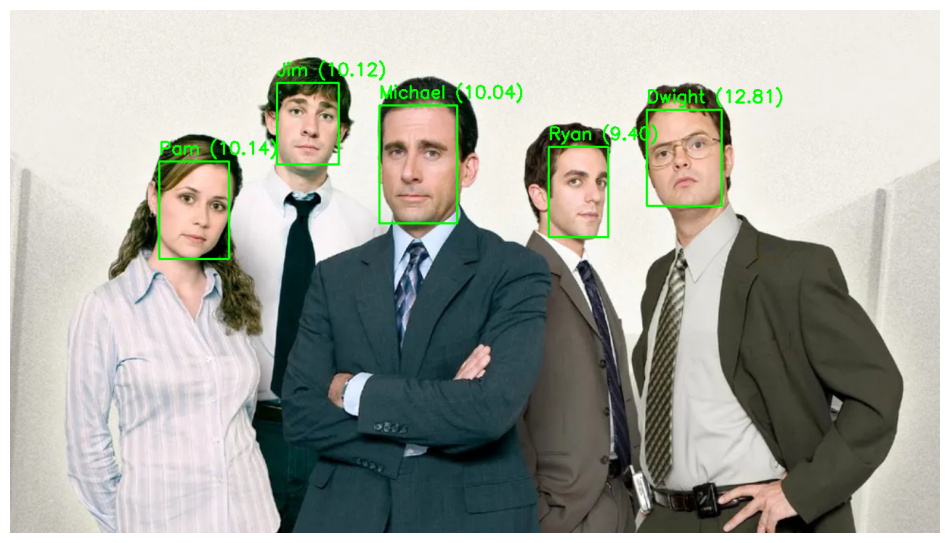

Classificações detectadas:
Face 1: Ryan (9.40)
Face 2: Jim (10.12)
Face 3: Pam (10.14)
Face 4: Dwight (12.81)
Face 5: Michael (10.04)


In [18]:
# caminho da imagem para ser analisada
image_path = 'the-office.jpg'

# chamado a função para detectar a classficar as faces
classifield_image, classfications = detect_faces_and_classify_names(image_path)

# exibir a imagem com as detecções e classficações
plt.figure(figsize=(12, 12))
plt.imshow(classifield_image)
plt.axis('off')
plt.show()

# exibir as classificações no console
print("Classificações detectadas:")
for idx, classification in enumerate(classfications):
    print(f"Face {idx + 1}: {classification}")